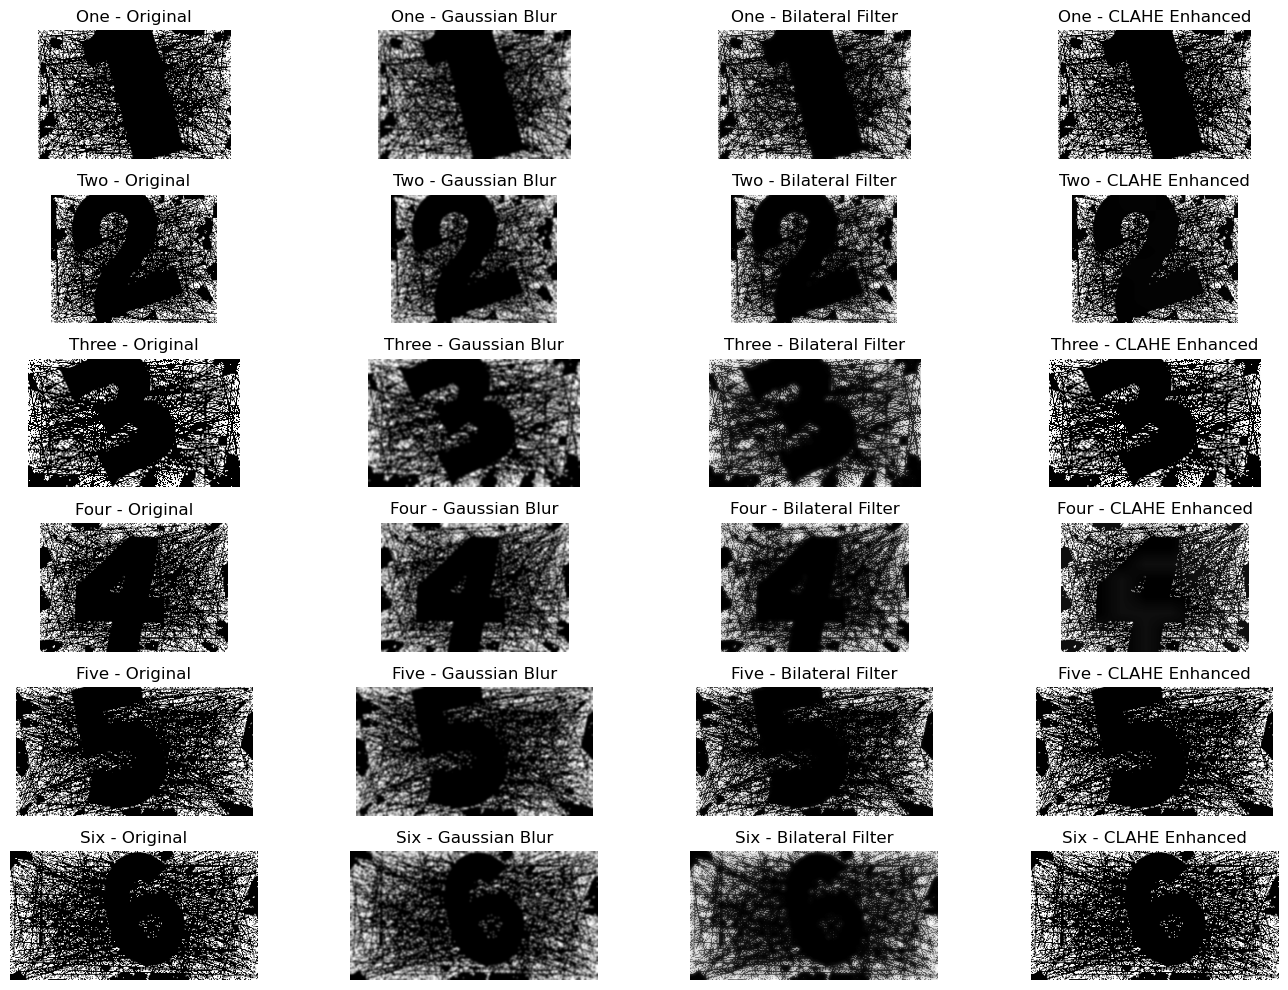

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_paths = {
    "One": r"Original_Images\1-173.png",
    "Two": r"Original_Images\2-47.png",
    "Three": r"Original_Images\3-47.png",
    "Four": r"Original_Images\4-165.png",
    "Five": r"Original_Images\5-47.png",
    "Six": r"Original_Images\6-80.png"
}

def apply_filters(image):
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 1)
    bilateral_filter = cv2.bilateralFilter(image, 9, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return image, gaussian_blur, bilateral_filter, clahe_image

results = {}
for label, path in image_paths.items():
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    results[label] = apply_filters(image)

fig, axes = plt.subplots(6, 4, figsize=(14, 10))

titles = ["Original", "Gaussian Blur", "Bilateral Filter", "CLAHE Enhanced"]

for i, (label, result) in enumerate(results.items()):
    for j, (img, title) in enumerate(zip(result, titles)):
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(f"{label} - {title}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


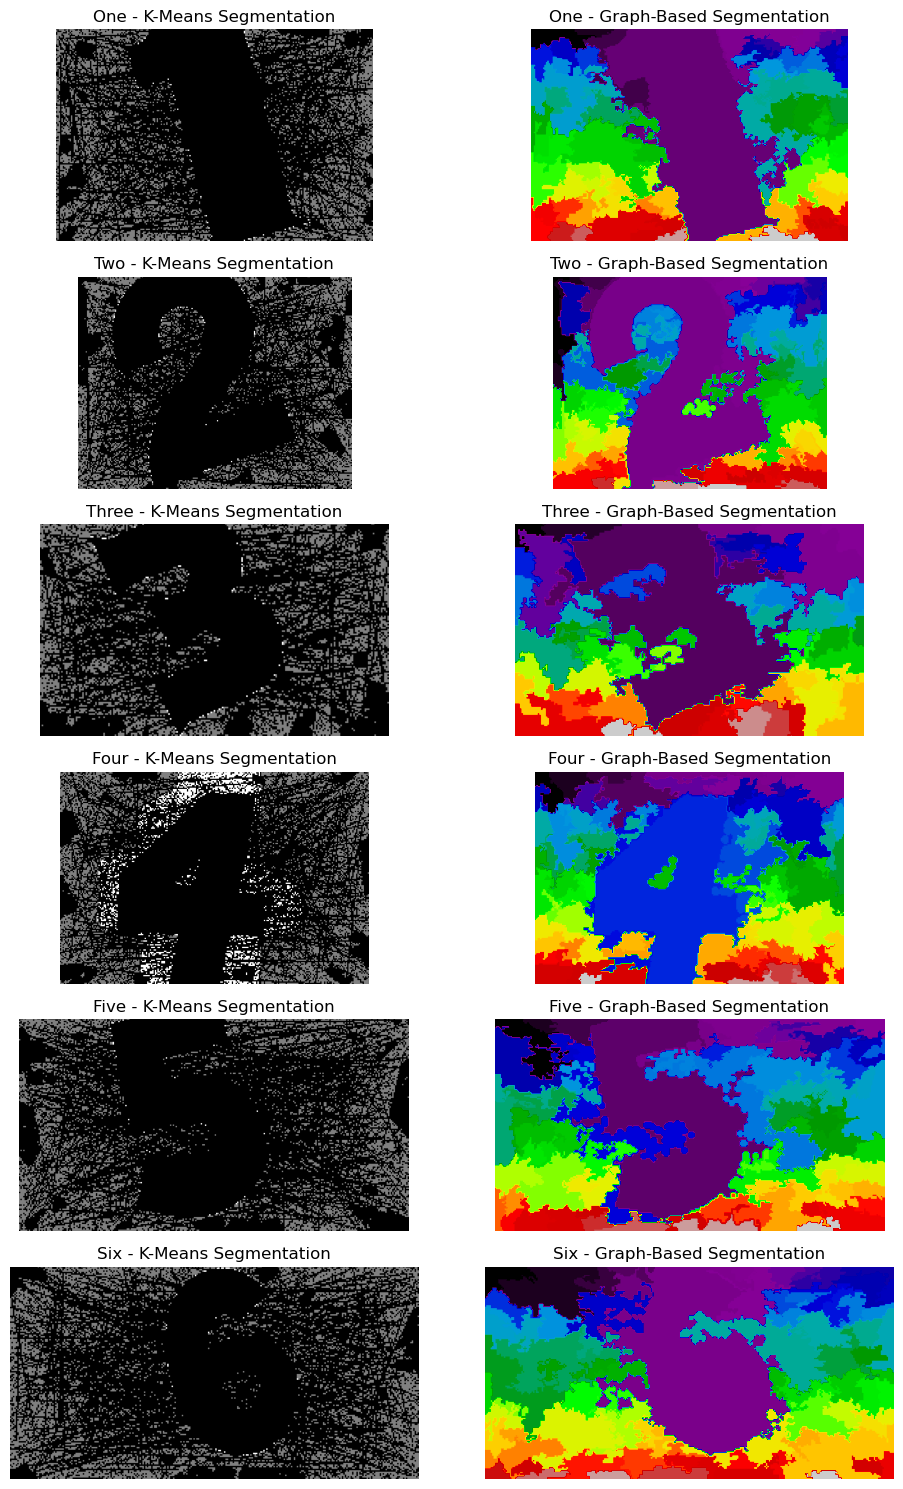

In [2]:
from skimage.segmentation import felzenszwalb
from sklearn.cluster import KMeans

def apply_kmeans(img, k=3):
    img_flat = img.reshape((-1, 1))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(img_flat)
    segmented_img = labels.reshape(img.shape)
    return segmented_img

segmentation_results = {}

for label, result in results.items():
    original, gaussian, bilateral, clahe = result  # Extract filtered images
    filtered_image = clahe  # Use CLAHE-enhanced image for segmentation

    kmeans_segmented = apply_kmeans(filtered_image, k=3)

    graph_segmented = felzenszwalb(cv2.cvtColor(original, cv2.COLOR_GRAY2RGB), scale=150, sigma=0.7, min_size=100)

    segmentation_results[label] = (kmeans_segmented, graph_segmented)

fig, axes = plt.subplots(6, 2, figsize=(10, 15))

for i, (label, (kmeans_img, graph_img)) in enumerate(segmentation_results.items()):
    axes[i, 0].imshow(kmeans_img, cmap='gray')
    axes[i, 0].set_title(f"{label} - K-Means Segmentation")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(graph_img, cmap='nipy_spectral')
    axes[i, 1].set_title(f"{label} - Graph-Based Segmentation")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


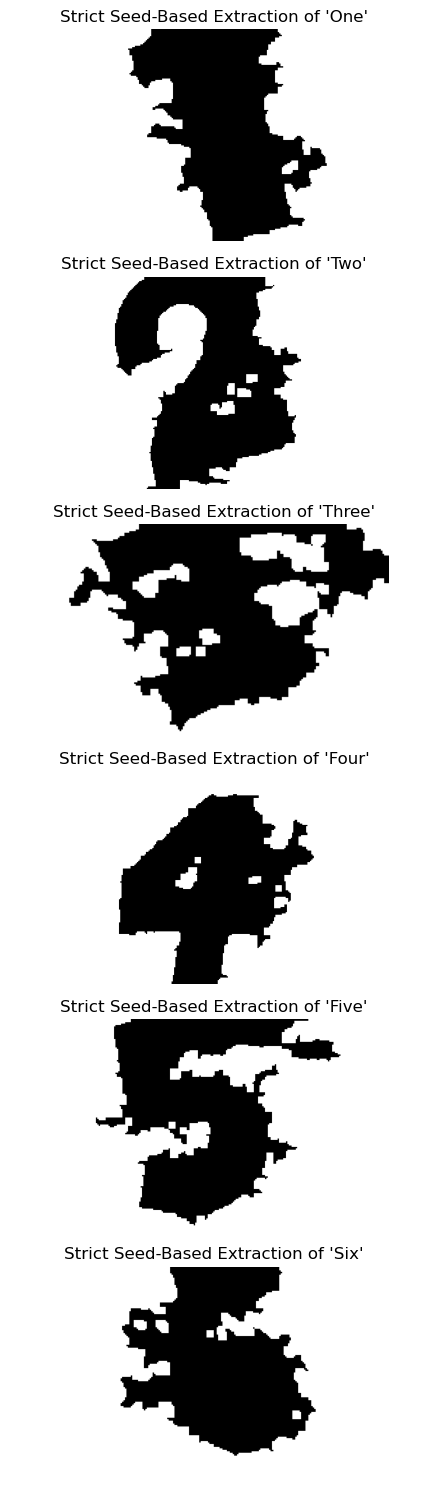

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def seed_based_segmentation(img, seed_point, color_threshold=5):
    """Extracts region with a strict color match to the seed point."""
    h, w, c = img.shape
    segmented = np.zeros((h, w), dtype=np.uint8)
    visited = np.zeros((h, w), dtype=bool)

    stack = [seed_point]
    seed_color = img[seed_point[0], seed_point[1]]

    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True

        color_diff = np.linalg.norm(img[x, y] - seed_color)

        if color_diff < color_threshold:
            segmented[x, y] = 255
            
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                    stack.append((nx, ny))

    return segmented

# Process Each Image
digit_masks = {}

for label, (_, graph_segmented) in segmentation_results.items():
    graph_segmented = graph_segmented.astype(np.uint8)

    # Convert to RGB if it's grayscale
    graph_segmented_rgb = cv2.cvtColor(graph_segmented, cv2.COLOR_GRAY2RGB) if len(graph_segmented.shape) == 2 else graph_segmented

    # Define seed point (center of image)
    seed_point = (graph_segmented_rgb.shape[0] // 2, graph_segmented_rgb.shape[1] // 2)

    # Apply Seed-Based Segmentation
    digit_mask = seed_based_segmentation(graph_segmented_rgb, seed_point, color_threshold=5)

    # Morphological Closing to Refine
    kernel = np.ones((5, 5), np.uint8)
    digit_mask = cv2.morphologyEx(digit_mask, cv2.MORPH_CLOSE, kernel)

    # Invert Mask
    digit_mask = cv2.bitwise_not(digit_mask)

    digit_masks[label] = digit_mask

# Plot Results
fig, axes = plt.subplots(6, 1, figsize=(6, 15))

for i, (label, mask) in enumerate(digit_masks.items()):
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"Strict Seed-Based Extraction of '{label}'")
    axes[i].axis("off")

plt.tight_layout()
plt.show()



### Evaluation Metrics for Segmented Digits ###
One: IoU = 0.9024, Dice = 0.9487, Pixel Accuracy = 0.9304
Two: IoU = 0.8548, Dice = 0.9217, Pixel Accuracy = 0.9012
Three: IoU = 0.7355, Dice = 0.8476, Pixel Accuracy = 0.8033
Four: IoU = 0.8945, Dice = 0.9443, Pixel Accuracy = 0.9214
Five: IoU = 0.8938, Dice = 0.9439, Pixel Accuracy = 0.9180
Six: IoU = 0.9031, Dice = 0.9491, Pixel Accuracy = 0.9212


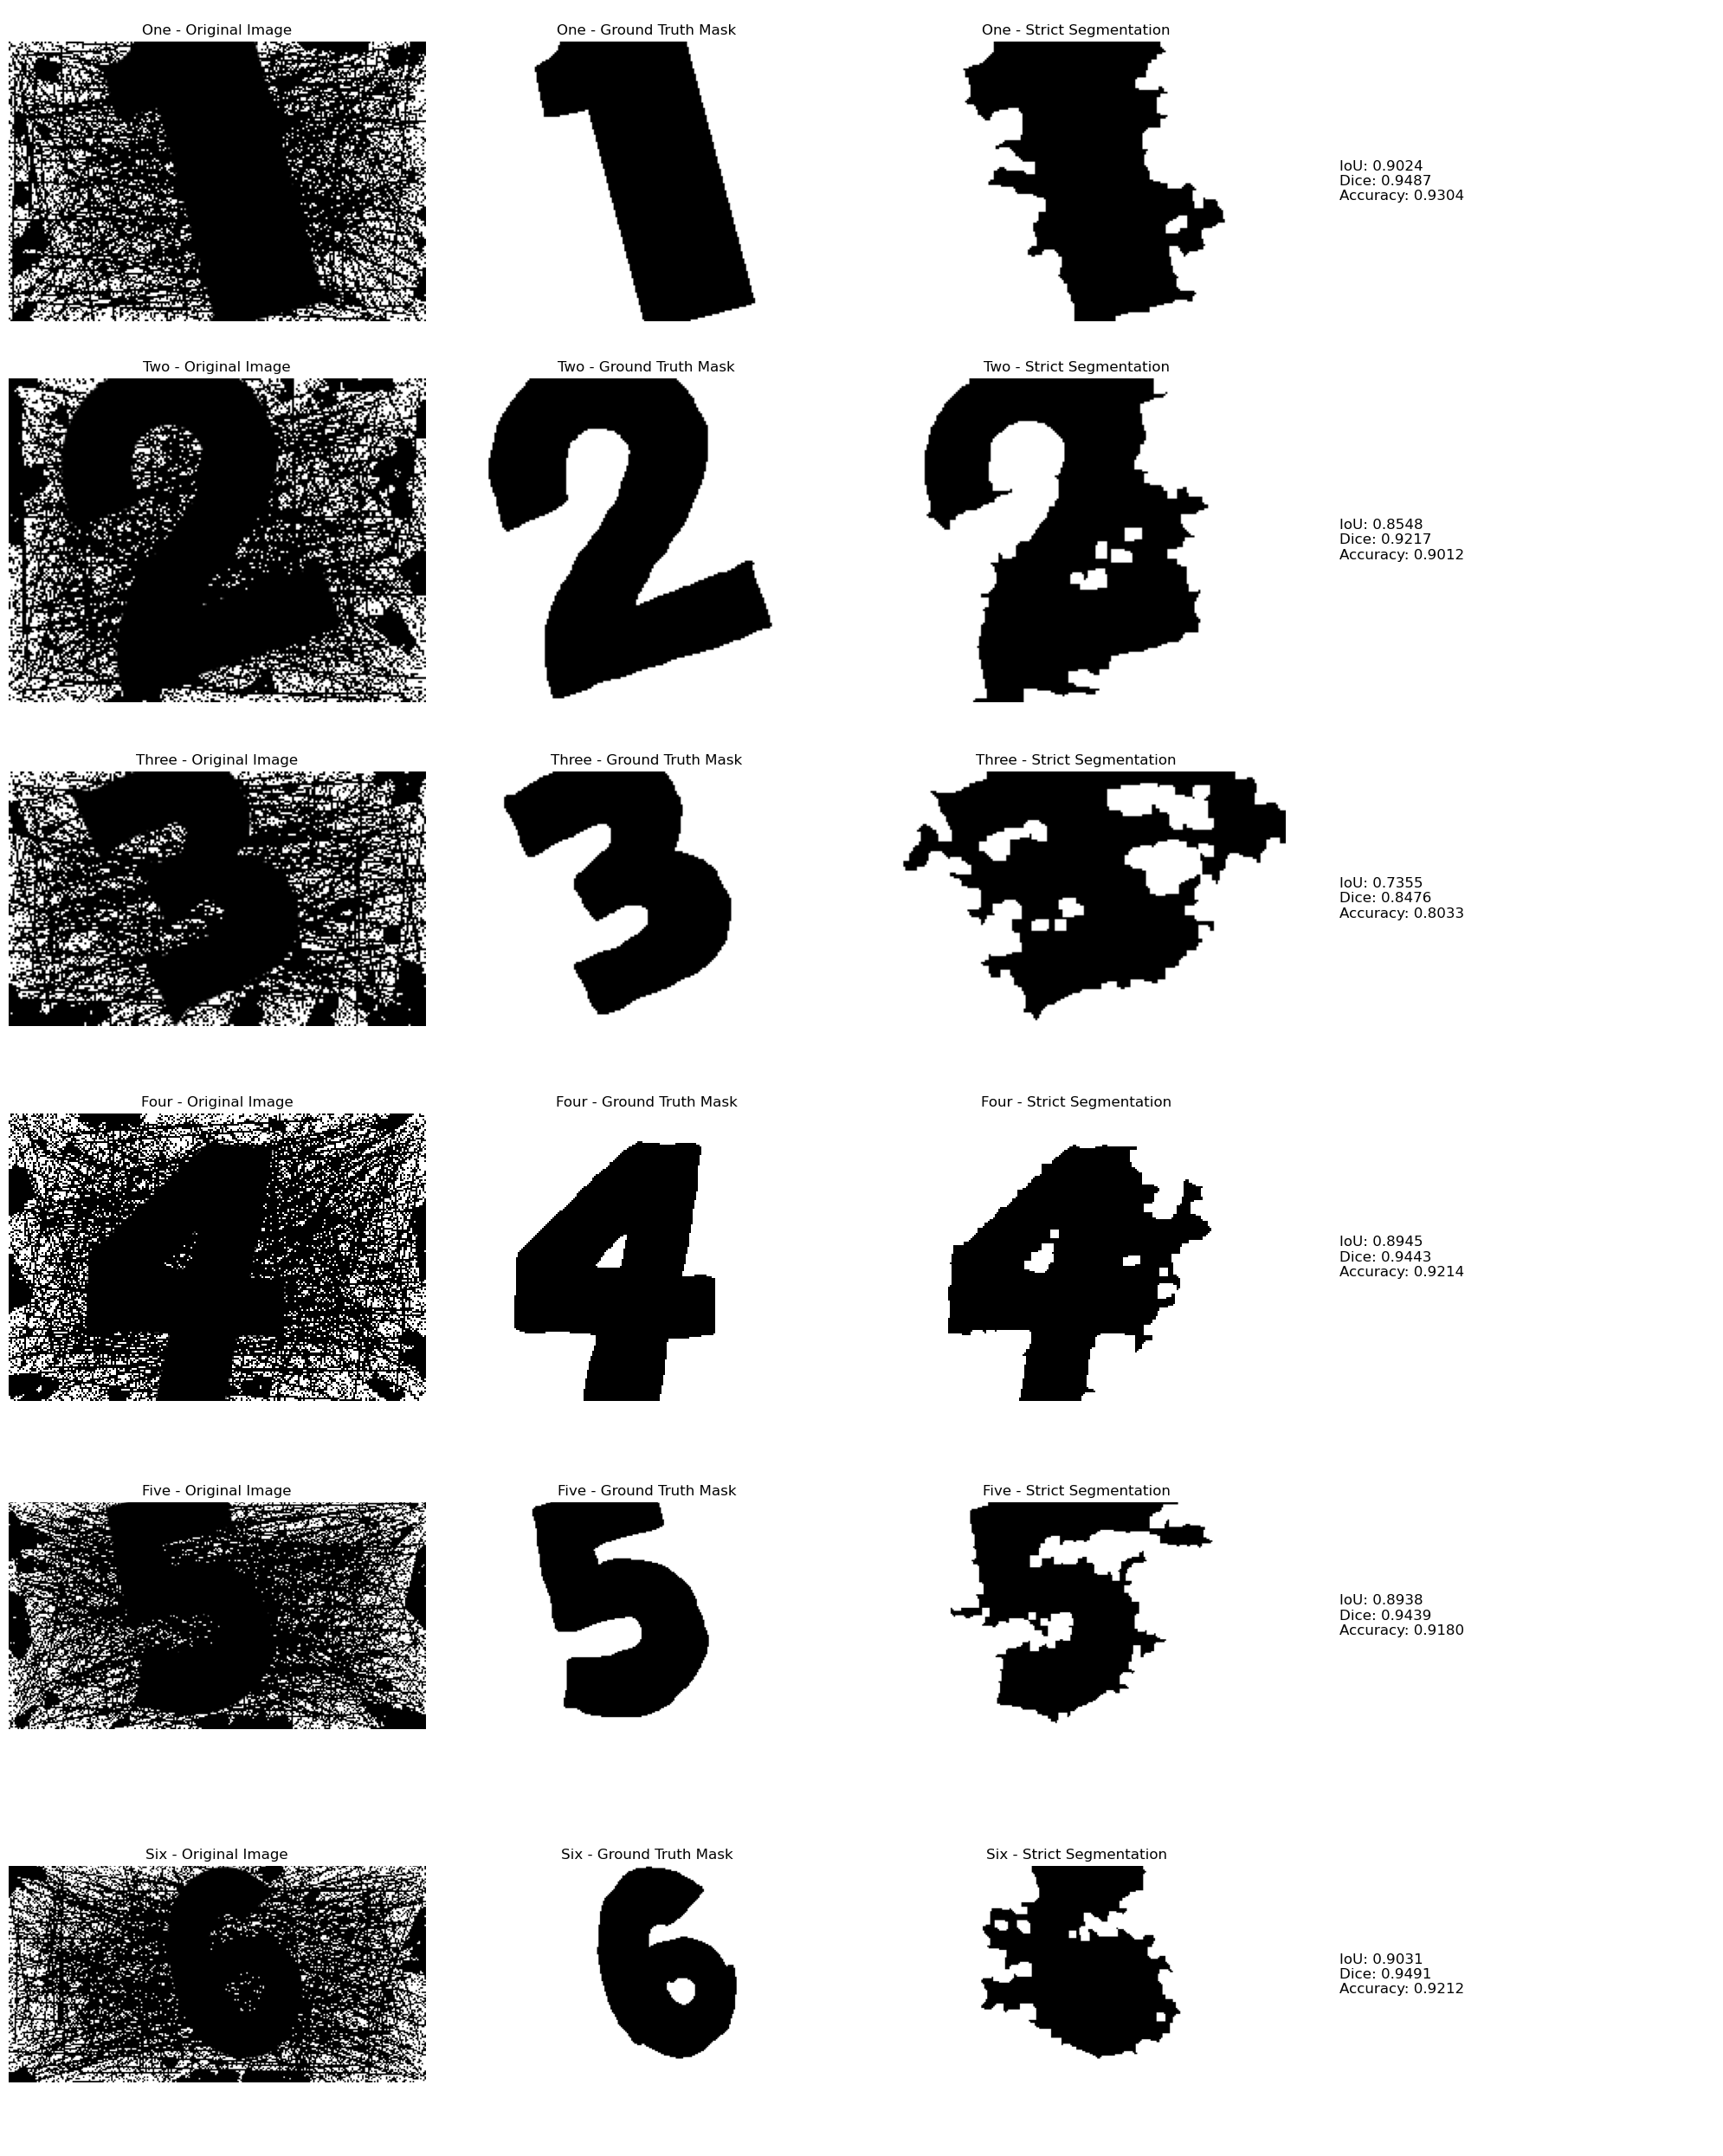

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(pred_mask, true_mask):
    """Computes Intersection over Union (IoU) between predicted and ground truth masks."""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def compute_dice(pred_mask, true_mask):
    """Computes Dice Coefficient between predicted and ground truth masks."""
    intersection = np.logical_and(pred_mask, true_mask).sum()
    dice = (2 * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) != 0 else 0
    return dice

def compute_pixel_accuracy(pred_mask, true_mask):
    """Computes Pixel Accuracy as (Correctly Classified Pixels / Total Pixels)."""
    correct_pixels = np.sum(pred_mask == true_mask)
    total_pixels = true_mask.size
    pixel_accuracy = correct_pixels / total_pixels
    return pixel_accuracy

# Paths for ground truth masks
true_mask_paths = {
    "One": r"Ground_Truth_Images\1-173.png",
    "Two": r"Ground_Truth_Images\2-47.png",
    "Three": r"Ground_Truth_Images\3-47.png",
    "Four": r"Ground_Truth_Images\4-165.png",
    "Five": r"Ground_Truth_Images\5-47.png",
    "Six": r"Ground_Truth_Images\6-80.jpg"
}

# Store evaluation metrics
metrics = {}

# Process Each Digit Using `digit_masks`
for label, pred_mask in digit_masks.items():
    # Load Original Image
    original_image = cv2.imread(image_paths[label], cv2.IMREAD_GRAYSCALE)

    # Load Ground Truth Mask
    true_mask_path = true_mask_paths[label]
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)

    # Error Handling for Missing Ground Truth
    if true_mask is None:
        raise FileNotFoundError(f"❌ Error: Ground truth mask not found at {true_mask_path}")

    # Convert Masks to Binary (0 or 1)
    true_mask = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255
    pred_mask = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)[1] // 255  # Using strict extraction mask

    # Compute Evaluation Metrics
    iou_score = compute_iou(pred_mask, true_mask)
    dice_score = compute_dice(pred_mask, true_mask)
    pixel_accuracy = compute_pixel_accuracy(pred_mask, true_mask)

    # Store Metrics
    metrics[label] = (iou_score, dice_score, pixel_accuracy)

# Print All Metrics
print("\n### Evaluation Metrics for Segmented Digits ###")
for label, (iou, dice, acc) in metrics.items():
    print(f"{label}: IoU = {iou:.4f}, Dice = {dice:.4f}, Pixel Accuracy = {acc:.4f}")

# Plot Results
fig, axes = plt.subplots(6, 4, figsize=(20, 25))

for i, label in enumerate(digit_masks.keys()):
    original_image = cv2.imread(image_paths[label], cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.imread(true_mask_paths[label], cv2.IMREAD_GRAYSCALE)

    # Convert Masks to Displayable Format
    true_mask = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)[1]
    pred_mask = digit_masks[label]  # Use strict seed-based segmentation output

    # Plot Original Image
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f"{label} - Original Image")
    axes[i, 0].axis("off")

    # Plot Ground Truth Mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title(f"{label} - Ground Truth Mask")
    axes[i, 1].axis("off")

    # Plot Final Segmented Image
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title(f"{label} - Strict Segmentation")
    axes[i, 2].axis("off")

    # Plot IoU & Dice Scores
    iou, dice, acc = metrics[label]
    axes[i, 3].text(0.1, 0.5, f"IoU: {iou:.4f}\nDice: {dice:.4f}\nAccuracy: {acc:.4f}", 
                    fontsize=12, ha='left', va='center')
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()



### Average Evaluation Metrics ###
Average IoU Score: 0.8640
Average Dice Coefficient: 0.9259
Average Pixel Accuracy: 0.8993


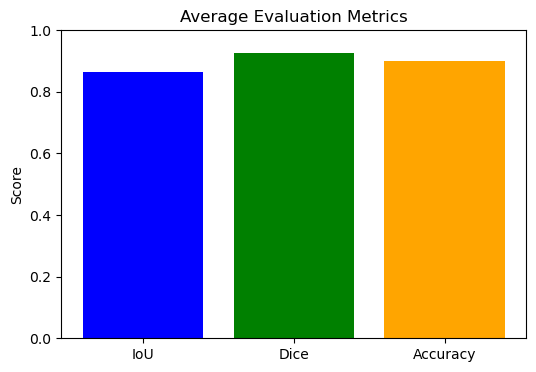

In [5]:
# Compute Average Metrics
avg_iou = np.mean([iou for iou, _, _ in metrics.values()])
avg_dice = np.mean([dice for _, dice, _ in metrics.values()])
avg_accuracy = np.mean([acc for _, _, acc in metrics.values()])

# Display Averages
print("\n### Average Evaluation Metrics ###")
print(f"Average IoU Score: {avg_iou:.4f}")
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average Pixel Accuracy: {avg_accuracy:.4f}")

# Optional: Display in a bar chart
plt.figure(figsize=(6, 4))
plt.bar(["IoU", "Dice", "Accuracy"], [avg_iou, avg_dice, avg_accuracy], color=["blue", "green", "orange"])
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Average Evaluation Metrics")
plt.show()
